In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch as T
import time

from google.colab import files

In [ ]:
class Cavity:
    def __init__(self, L = 1, H = 1, Re = 100, nx = 101, ny=101, U_up =1, U_down = 0, U_left = 0, U_right = 0):
        self.L = L
        self.H = H
        self.Re = Re
        self.nx = nx
        self.ny = ny

        self.U_up = U_up
        self.U_down = U_down
        self.U_left = U_left
        self.U_right = U_right

        self.nu = U_up * L / Re
        
        self.delta_x = L / (nx - 1)
        self.delta_y = H / (ny - 1)
        self.beta =self.delta_x / self.delta_y
        self.beta2 = self.beta ** 2

        self.sf = np.zeros((nx,ny))
        self.w = np.zeros((nx,ny))
        self.u = np.zeros((nx,ny))
        self.v = np.zeros((nx,ny))

        self.u[0,:] = U_down 
        self.u[-1,:] = U_up 
        self.v[:,0] = U_left
        self.v[:,-1] = U_right

        self.device = T.device("cuda" if T.cuda.is_available() else "cpu")

        self.sf_residuals = []
        self.w_residuals = []
        self.u_residuals = []
        self.v_residuals = []

        self.sf_imgs = []
        self.w_imgs  = []
        self.v_imgs  = []
        self.u_imgs  = []
        self.V_total = []

        self.step = 0

    def sf_update_roll_T(self):
        sf = T.tensor(self.sf,device=self.device)
        w = T.tensor(self.w, device=self.device)
        sf[1:-1,1:-1] = ((T.roll(sf,1,0) + T.roll(sf,-1,0) +\
                        self.beta2 * T.roll(sf,1,1) + self.beta2* T.roll(sf,-1,1) +\
                        (self.delta_x ** 2) * w) / (2 + 2*self.beta2))[1:-1,1:-1]

        return sf.cpu().detach().numpy()

    def w_update_roll_T(self):
        sf = T.tensor(self.sf, device=self.device)
        w = T.tensor(self.w, device=self.device)
        u = T.tensor(self.u, device=self.device)
        v = T.tensor(self.v, device=self.device)

        w[0,:] = -2 * (sf[1,:]+ self.delta_x * u[0,:]) / (self.delta_x **2)
        w[-1,:] = -2 * (sf[-2,:]+ self.delta_x * u[-1,:]) / (self.delta_x **2)
        w[:,0] = -2 * (sf[:,1] + self.delta_y * v[:,0]) / (self.delta_y **2)
        w[:,-1] = -2 * (sf[:,-2] + self.delta_y * v[:,-1]) / (self.delta_y **2)


        u[1:-1,1:-1]  = ((T.roll(sf,1,1) - T.roll(sf,-1,1)) / (2 * self.delta_y))[1:-1,1:-1] 
        v[1:-1,1:-1] = -((T.roll(sf,1,0) - T.roll(sf,-1,0)) / (2 * self.delta_x))[1:-1,1:-1] 

        dwdx = (T.roll(w,1,0) - T.roll(w,-1,0))/(2 * self.delta_x)
        dwdy = (T.roll(w,1,1) - T.roll(w,-1,1))/(2 * self.delta_y)

        A = (u * dwdx + v * dwdy)/ self.nu

        w[1:-1,1:-1] = ((T.roll(w,1,0) + T.roll(w,-1,0) + self.beta2*T.roll(w,1,1) +\
                         self.beta2 * T.roll(w,-1,1)- (self.delta_x**2) * A)/(2 + 2*self.beta2))[1:-1,1:-1]

        return w.cpu().detach().numpy(), u.cpu().detach().numpy(), v.cpu().detach().numpy()

    def solve(self,residual_target, frame):
        self.residual_target = residual_target

        Error = 1000

        startTime = time.time()
        while (Error > self.residual_target):
            sf_new = self.sf_update_roll_T()

            w_new, u_new, v_new = self.w_update_roll_T()

            error_sf = np.max(np.abs(sf_new - self.sf))
            error_w  = np.max(np.abs(w_new  - self.w))
            error_u  = np.max(np.abs(u_new  - self.u))
            error_v  = np.max(np.abs(v_new  - self.v))

            Error = max([error_sf, error_w, error_v, error_u])
            print("{} - {:.4e}      {:.4e}      {:.4e}      {:.4e}".format(self.step, error_sf,error_w,error_u, error_v))

            self.sf = sf_new
            self.w = w_new
            self.u = u_new
            self.v = v_new

            self.sf_residuals.append(error_sf)
            self.w_residuals.append(error_w)
            self.v_residuals.append(error_v)
            self.u_residuals.append(error_u)

            if (self.step % frame == 0):
                self.sf_imgs.append(self.sf)
                self.w_imgs.append(self.w)
                self.u_imgs.append(self.u)
                self.v_imgs.append(self.v)
                self.V_total.append( np.sqrt(self.u**2 + self.v**2))

            self.step += 1

        print('---------------------------')
        print("Run time: {:e}".format(time.time() -startTime))

    def plot_residuals(self):
        plt.figure(figsize=(10,5))
        plt.yscale('log')
        plt.plot(self.sf_residuals,label='stream function residual')
        plt.plot(self.w_residuals, label='vorticity residual')
        plt.plot(self.u_residuals, label='u residual')
        plt.plot(self.v_residuals, label='v residual')
        plt.legend()
        plt.xlabel('iteration')
        plt.ylabel('Error')
        _ = plt.title("solution residuals")

    def plot_stream(self):
        plt.figure(figsize=(12,10))
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        plt.contour(self.sf, 50,colors='k',linewidths=0.8)
        plt.contourf(self.sf,50,cmap='jet')
        plt.title("Stream function - Re:{}, {}x{}".format(self.Re,self.nx, self.ny))
        plt.colorbar()

    def plot_vorticity(self):
        plt.figure(figsize=(12,10))
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        plt.contour(self.w,1000,colors='k',linewidths=0.8)
        plt.contourf(self.w,1000,cmap='hot')
        plt.title("Vorticity")
        plt.colorbar()

    def plot_u(self):
        plt.figure(figsize=(12,10))
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        plt.contour(self.u,100,colors='k',linewidths=0.8)
        plt.contourf(self.u,100,cmap='jet')
        plt.title("u velocity")

    def plot_v(self):
        plt.figure(figsize=(12,10))
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        plt.contour(self.v,100,colors='k',linewidths=0.8)
        plt.contourf(self.v,100,cmap='jet')
        plt.title("v velocity")

    def plot_Velocity(self):
        plt.figure(figsize=(12,10))
        plt.rcParams['contour.negative_linestyle'] = 'solid'
        V_total = np.sqrt(self.u**2 + self.v**2)
        plt.contour(V_total, 100, colors='k',linewidths=0.8)
        plt.contourf(V_total, 100, cmap='jet')
        plt.title("Velocity Magnitude")

    def plot_streamlines(self):
        plt.figure(figsize=(12,10))
        plt.rcParams['contour.negative_linestyle'] = 'solid'

        x = np.linspace(0, C.H, self.ny)
        y = np.linspace(0, C.L, self.nx)

        X, Y = np.meshgrid(x, y)

        self.V_total = np.sqrt(self.u**2 + self.v**2)
        plt.streamplot(X, Y, C.v, C.u , density=2 , color =self.V_total, cmap='hot')
        plt.title("Streamlines - Re:{}, {}x{}".format(self.Re,self.nx, self.ny))
        plt.colorbar()

# Re = 100

In [ ]:
Re = 100
nx = 101
ny = 101
C = Cavity(Re=Re,nx=nx,ny=ny)
C.solve(1e-05,10000)

Streaming output truncated to the last 5000 lines.
5197 - 2.5770e-06      1.8004e-04      1.0430e-05      1.1269e-05
5198 - 2.5769e-06      1.7997e-04      1.0427e-05      1.1266e-05
5199 - 2.5769e-06      1.7978e-04      1.0426e-05      1.1261e-05
5200 - 2.5767e-06      1.7970e-04      1.0422e-05      1.1259e-05
5201 - 2.5767e-06      1.7951e-04      1.0421e-05      1.1253e-05
5202 - 2.5764e-06      1.7944e-04      1.0418e-05      1.1251e-05
5203 - 2.5765e-06      1.7925e-04      1.0417e-05      1.1245e-05
5204 - 2.5762e-06      1.7917e-04      1.0413e-05      1.1243e-05
5205 - 2.5764e-06      1.7898e-04      1.0412e-05      1.1238e-05
5206 - 2.5760e-06      1.7891e-04      1.0409e-05      1.1235e-05
5207 - 2.5762e-06      1.7872e-04      1.0408e-05      1.1230e-05
5208 - 2.5758e-06      1.7864e-04      1.0404e-05      1.1228e-05
5209 - 2.5760e-06      1.7845e-04      1.0404e-05      1.1222e-05
5210 - 2.5756e-06      1.7838e-04      1.0400e-05      1.1220e-05
5211 - 2.5758e-06      1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

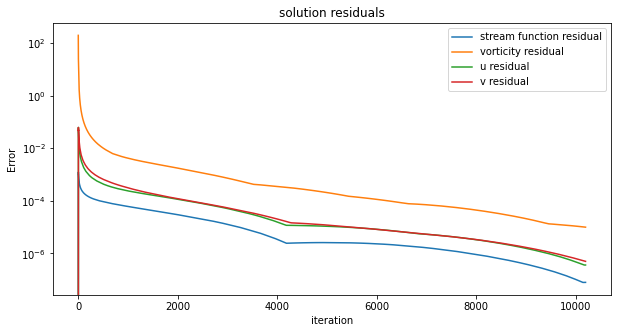

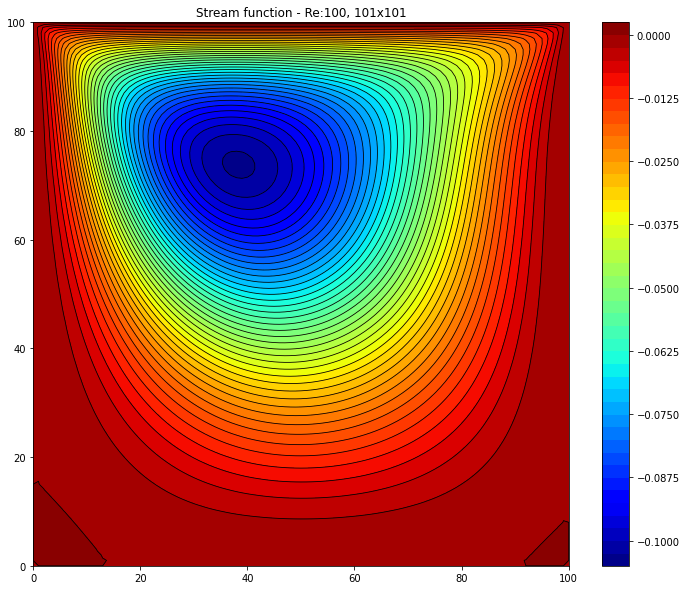

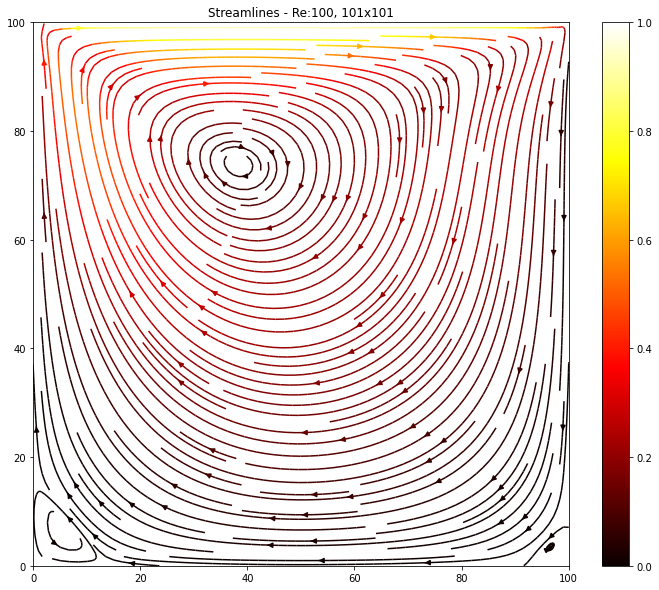

In [ ]:
C.plot_residuals()
C.plot_stream()
C.plot_streamlines()

# Re =400

In [ ]:
Re = 400
nx = 201
ny = 201
C = Cavity(Re=Re,nx=nx,ny=ny)
C.solve(1e-05,10000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

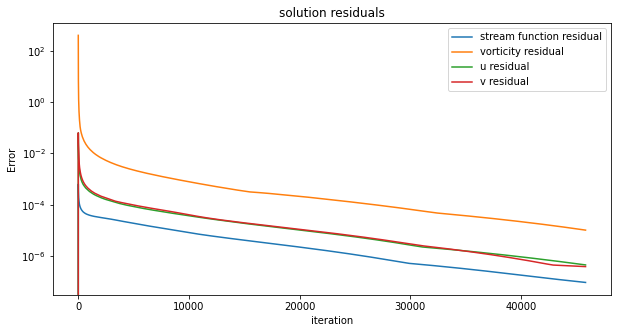

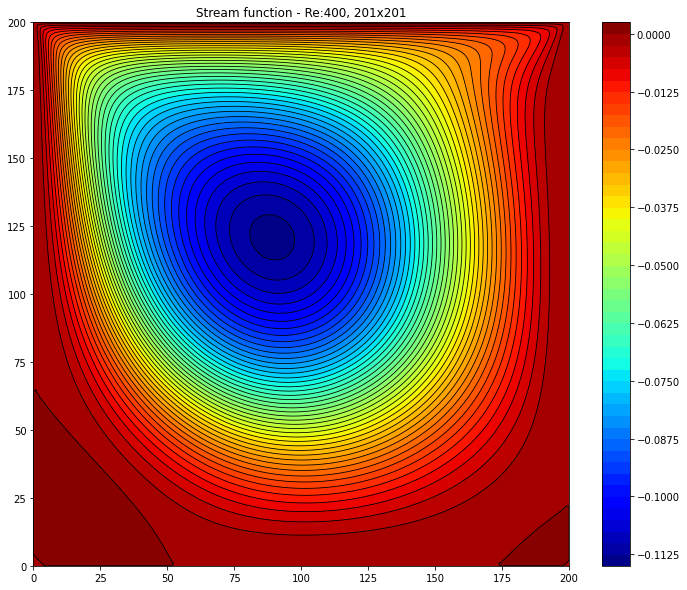

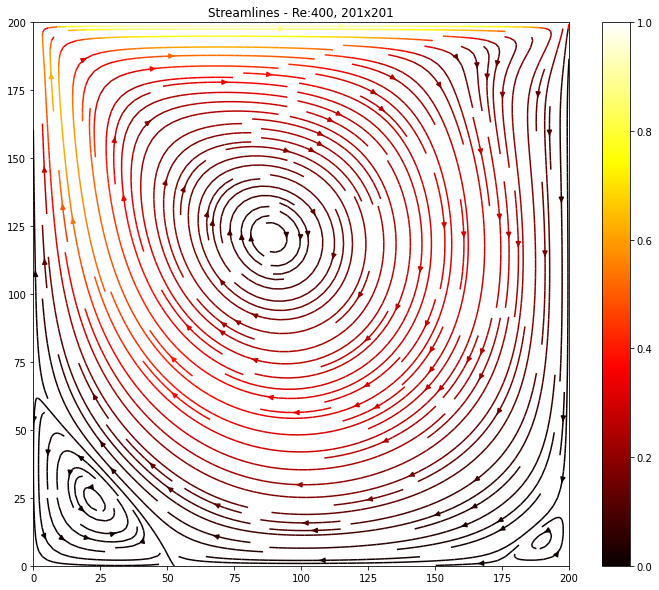

In [ ]:
C.plot_residuals()
C.plot_stream()
C.plot_streamlines()

# Re =1000

In [ ]:
Re = 1000
nx = 251
ny = 251
C = Cavity(Re=Re,nx=nx,ny=ny)
C.solve(1e-05,10000)

Streaming output truncated to the last 5000 lines.
89341 - 6.1623e-08      1.6730e-05      4.2019e-07      3.4813e-07
89342 - 6.1618e-08      1.6728e-05      4.2015e-07      3.4811e-07
89343 - 6.1614e-08      1.6727e-05      4.2011e-07      3.4810e-07
89344 - 6.1609e-08      1.6725e-05      4.2008e-07      3.4808e-07
89345 - 6.1605e-08      1.6723e-05      4.2004e-07      3.4806e-07
89346 - 6.1600e-08      1.6722e-05      4.2000e-07      3.4804e-07
89347 - 6.1596e-08      1.6720e-05      4.1996e-07      3.4803e-07
89348 - 6.1591e-08      1.6719e-05      4.1993e-07      3.4801e-07
89349 - 6.1587e-08      1.6717e-05      4.1989e-07      3.4799e-07
89350 - 6.1582e-08      1.6715e-05      4.1985e-07      3.4797e-07
89351 - 6.1577e-08      1.6714e-05      4.1982e-07      3.4796e-07
89352 - 6.1573e-08      1.6712e-05      4.1978e-07      3.4794e-07
89353 - 6.1568e-08      1.6711e-05      4.1974e-07      3.4792e-07
89354 - 6.1564e-08      1.6709e-05      4.1970e-07      3.4791e-07
89355 - 6.1

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

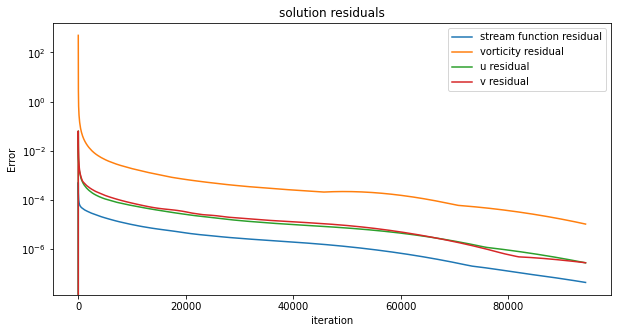

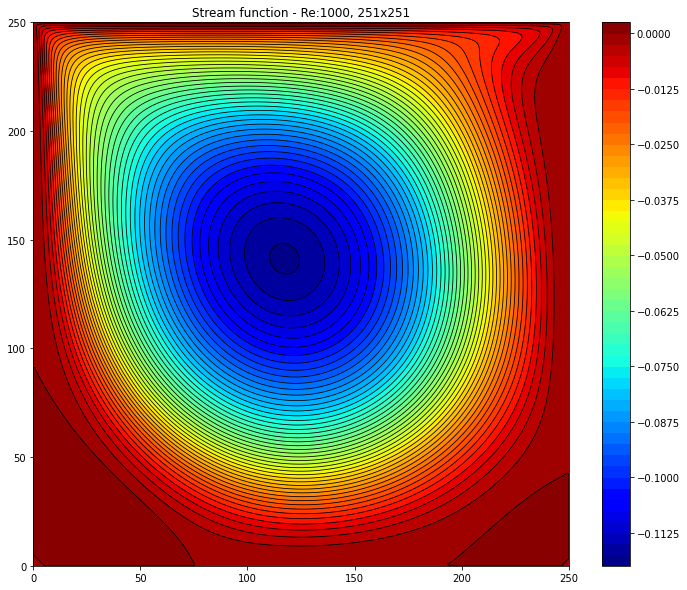

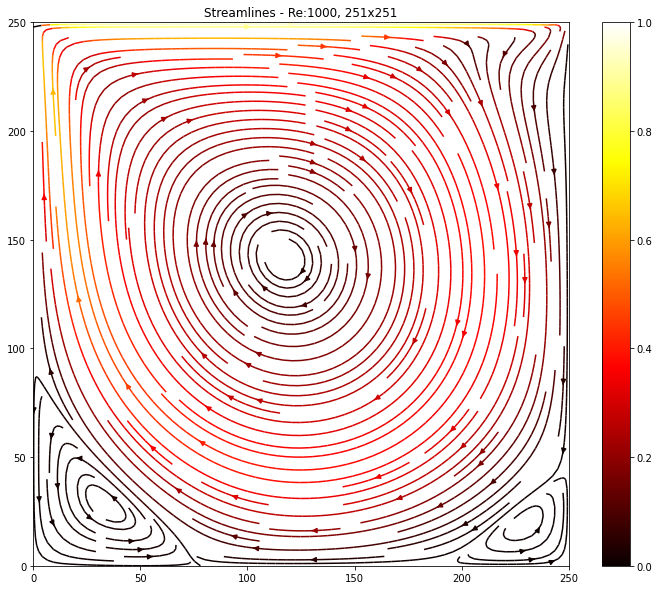

In [ ]:
C.plot_residuals()
C.plot_stream()
C.plot_streamlines()
plt.savefig('Re1000.svg')
files.download("Re1000.svg")

# LxH comp

Streaming output truncated to the last 5000 lines.
4894 - 1.6091e-06      1.3189e-04      7.3962e-06      7.7347e-06
4895 - 1.6089e-06      1.3182e-04      7.3945e-06      7.7337e-06
4896 - 1.6093e-06      1.3175e-04      7.3940e-06      7.7305e-06
4897 - 1.6091e-06      1.3167e-04      7.3928e-06      7.7295e-06
4898 - 1.6095e-06      1.3160e-04      7.3919e-06      7.7264e-06
4899 - 1.6093e-06      1.3153e-04      7.3912e-06      7.7253e-06
4900 - 1.6097e-06      1.3146e-04      7.3897e-06      7.7222e-06
4901 - 1.6095e-06      1.3138e-04      7.3894e-06      7.7211e-06
4902 - 1.6100e-06      1.3131e-04      7.3875e-06      7.7180e-06
4903 - 1.6098e-06      1.3124e-04      7.3877e-06      7.7169e-06
4904 - 1.6102e-06      1.3117e-04      7.3853e-06      7.7138e-06
4905 - 1.6100e-06      1.3109e-04      7.3860e-06      7.7127e-06
4906 - 1.6104e-06      1.3102e-04      7.3835e-06      7.7096e-06
4907 - 1.6102e-06      1.3095e-04      7.3843e-06      7.7085e-06
4908 - 1.6106e-06      1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

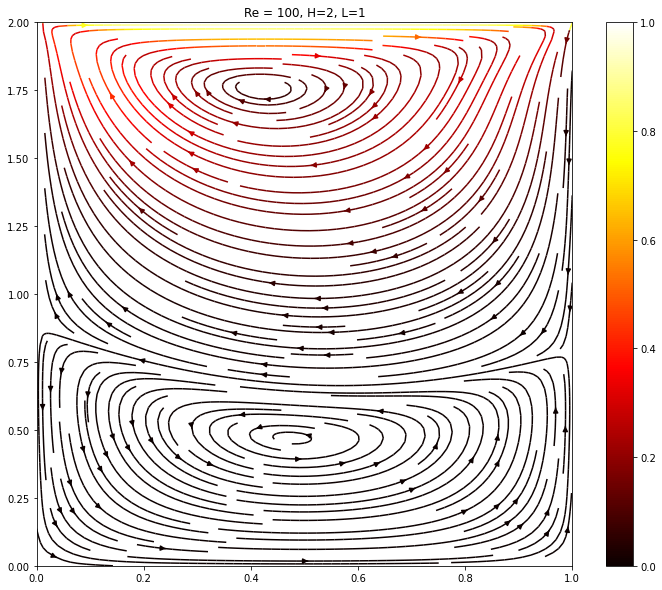

In [ ]:
L = 2
H = 1
C = Cavity(L = L, H = H, Re = 100 ,nx =int(L *100) + 1, ny = int(H *100) + 1)
C.solve(1e-05,10000)
C.plot_streamlines()
plt.title('Re = 100, H={}, L={}'.format(L,H))
plt.savefig("{}x{}.svg".format(L,H))
files.download("{}x{}.svg".format(L,H))

Streaming output truncated to the last 5000 lines.
5302 - 1.8012e-06      1.2796e-04      7.7863e-06      8.0316e-06
5303 - 1.8015e-06      1.2792e-04      7.7873e-06      8.0316e-06
5304 - 1.8011e-06      1.2779e-04      7.7835e-06      8.0260e-06
5305 - 1.8013e-06      1.2776e-04      7.7845e-06      8.0260e-06
5306 - 1.8011e-06      1.2762e-04      7.7808e-06      8.0206e-06
5307 - 1.8011e-06      1.2759e-04      7.7818e-06      8.0204e-06
5308 - 1.8010e-06      1.2746e-04      7.7780e-06      8.0157e-06
5309 - 1.8009e-06      1.2743e-04      7.7790e-06      8.0148e-06
5310 - 1.8009e-06      1.2729e-04      7.7753e-06      8.0107e-06
5311 - 1.8007e-06      1.2726e-04      7.7763e-06      8.0093e-06
5312 - 1.8009e-06      1.2713e-04      7.7725e-06      8.0057e-06
5313 - 1.8005e-06      1.2710e-04      7.7735e-06      8.0041e-06
5314 - 1.8008e-06      1.2696e-04      7.7697e-06      8.0008e-06
5315 - 1.8004e-06      1.2693e-04      7.7707e-06      7.9990e-06
5316 - 1.8007e-06      1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

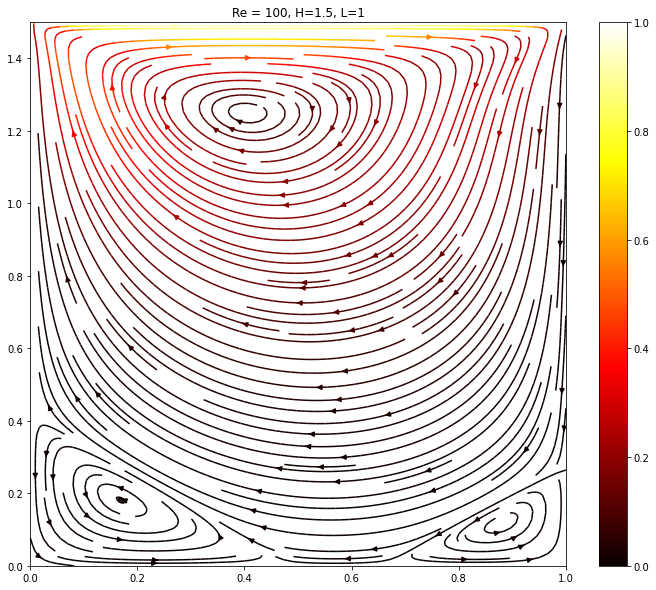

In [ ]:
L = 1.5
H = 1
C = Cavity(L = L, H = H, Re = 100 ,nx =int(L *100) + 1, ny = int(H *100) + 1)
C.solve(1e-05,10000)
C.plot_streamlines()
plt.title('Re = 100, H={}, L={}'.format(L,H))
plt.savefig("{}x{}.svg".format(L,H))
files.download("{}x{}.svg".format(L,H))

Streaming output truncated to the last 5000 lines.
5197 - 2.5770e-06      1.8004e-04      1.0430e-05      1.1269e-05
5198 - 2.5769e-06      1.7997e-04      1.0427e-05      1.1266e-05
5199 - 2.5769e-06      1.7978e-04      1.0426e-05      1.1261e-05
5200 - 2.5767e-06      1.7970e-04      1.0422e-05      1.1259e-05
5201 - 2.5767e-06      1.7951e-04      1.0421e-05      1.1253e-05
5202 - 2.5764e-06      1.7944e-04      1.0418e-05      1.1251e-05
5203 - 2.5765e-06      1.7925e-04      1.0417e-05      1.1245e-05
5204 - 2.5762e-06      1.7917e-04      1.0413e-05      1.1243e-05
5205 - 2.5764e-06      1.7898e-04      1.0412e-05      1.1238e-05
5206 - 2.5760e-06      1.7891e-04      1.0409e-05      1.1235e-05
5207 - 2.5762e-06      1.7872e-04      1.0408e-05      1.1230e-05
5208 - 2.5758e-06      1.7864e-04      1.0404e-05      1.1228e-05
5209 - 2.5760e-06      1.7845e-04      1.0404e-05      1.1222e-05
5210 - 2.5756e-06      1.7838e-04      1.0400e-05      1.1220e-05
5211 - 2.5758e-06      1.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

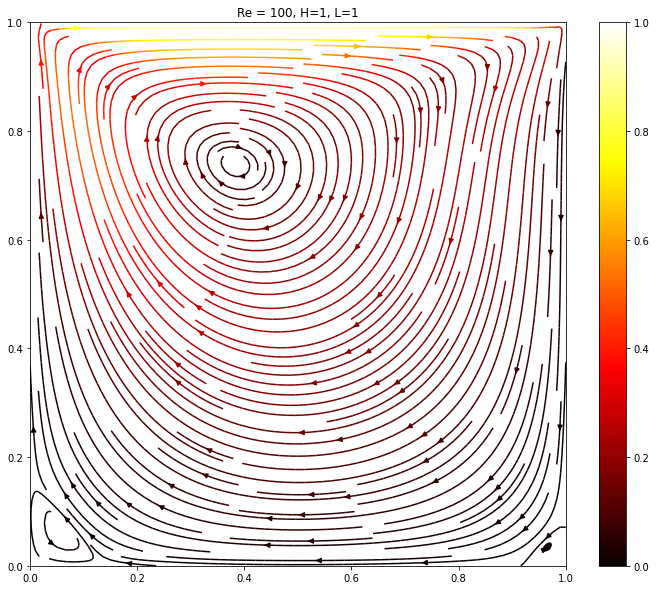

In [ ]:
L = 1
H = 1
C = Cavity(L = L, H = H, Re = 100 ,nx =int(L *100) + 1, ny = int(H *100) + 1)
C.solve(1e-05,10000)
C.plot_streamlines()
plt.title('Re = 100, H={}, L={}'.format(L,H))
plt.savefig("{}x{}.svg".format(L,H))
files.download("{}x{}.svg".format(L,H))

Streaming output truncated to the last 5000 lines.
11214 - 1.8245e-06      7.6632e-05      4.2823e-06      6.7097e-06
11215 - 1.8235e-06      7.6595e-05      4.2808e-06      6.7064e-06
11216 - 1.8225e-06      7.6559e-05      4.2791e-06      6.7032e-06
11217 - 1.8215e-06      7.6522e-05      4.2775e-06      6.6999e-06
11218 - 1.8205e-06      7.6486e-05      4.2759e-06      6.6967e-06
11219 - 1.8196e-06      7.6449e-05      4.2743e-06      6.6933e-06
11220 - 1.8185e-06      7.6413e-05      4.2726e-06      6.6902e-06
11221 - 1.8176e-06      7.6376e-05      4.2711e-06      6.6868e-06
11222 - 1.8165e-06      7.6340e-05      4.2694e-06      6.6837e-06
11223 - 1.8156e-06      7.6303e-05      4.2678e-06      6.6803e-06
11224 - 1.8146e-06      7.6267e-05      4.2662e-06      6.6772e-06
11225 - 1.8136e-06      7.6230e-05      4.2646e-06      6.6738e-06
11226 - 1.8126e-06      7.6194e-05      4.2629e-06      6.6707e-06
11227 - 1.8116e-06      7.6157e-05      4.2614e-06      6.6673e-06
11228 - 1.8

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

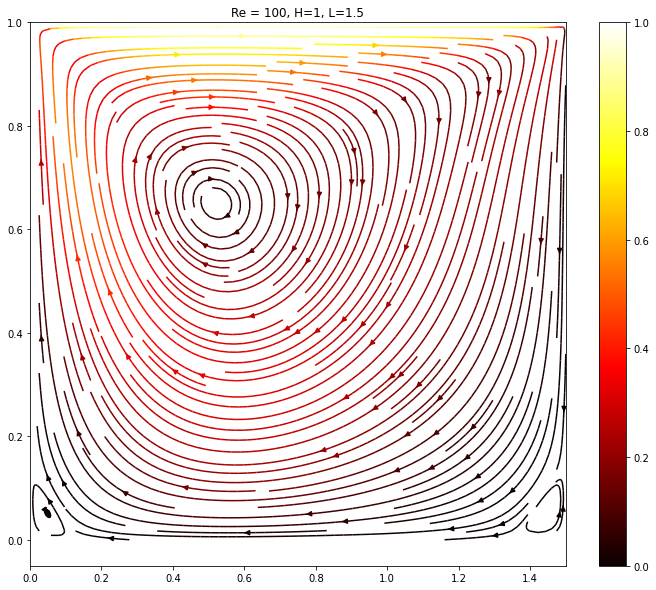

In [ ]:
L = 1
H = 1.5
C = Cavity(L = L, H = H, Re = 100 ,nx =int(L *100) + 1, ny = int(H *100) + 1)
C.solve(1e-05,10000)
C.plot_streamlines()
plt.title('Re = 100, H={}, L={}'.format(L,H))
plt.savefig("{}x{}.svg".format(L,H))
files.download("{}x{}.svg".format(L,H))

Streaming output truncated to the last 5000 lines.
16855 - 8.8536e-07      3.5828e-05      1.6439e-06      2.9990e-06
16856 - 8.8528e-07      3.5819e-05      1.6434e-06      2.9985e-06
16857 - 8.8518e-07      3.5810e-05      1.6430e-06      2.9980e-06
16858 - 8.8510e-07      3.5802e-05      1.6426e-06      2.9975e-06
16859 - 8.8500e-07      3.5792e-05      1.6422e-06      2.9971e-06
16860 - 8.8492e-07      3.5784e-05      1.6418e-06      2.9966e-06
16861 - 8.8482e-07      3.5775e-05      1.6414e-06      2.9962e-06
16862 - 8.8474e-07      3.5767e-05      1.6410e-06      2.9957e-06
16863 - 8.8464e-07      3.5757e-05      1.6406e-06      2.9952e-06
16864 - 8.8456e-07      3.5749e-05      1.6402e-06      2.9947e-06
16865 - 8.8446e-07      3.5740e-05      1.6398e-06      2.9943e-06
16866 - 8.8437e-07      3.5731e-05      1.6393e-06      2.9938e-06
16867 - 8.8428e-07      3.5722e-05      1.6389e-06      2.9934e-06
16868 - 8.8419e-07      3.5714e-05      1.6385e-06      2.9929e-06
16869 - 8.8

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

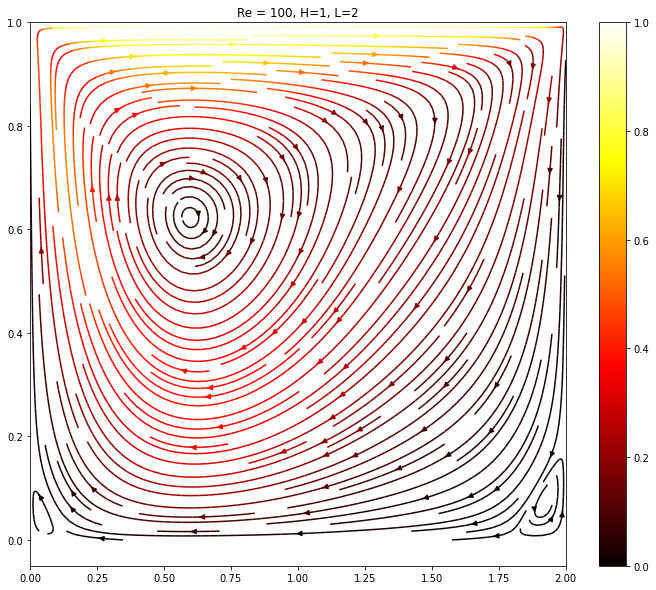

In [ ]:
L = 1
H = 2
C = Cavity(L = L, H = H, Re = 100 ,nx =int(L *100) + 1, ny = int(H *100) + 1)
C.solve(1e-05,10000)
C.plot_streamlines()
plt.title('Re = 100, H={}, L={}'.format(L,H))
plt.savefig("{}x{}.svg".format(L,H))
files.download("{}x{}.svg".format(L,H))

# plot line

In [ ]:
L = 1
H = 1

C3 = Cavity(L = L, H = H, Re = 100 ,nx =201,ny=201)
C3.solve(5e-04,10000)

Streaming output truncated to the last 5000 lines.
2400 - 2.1095e-05      1.9447e-03      9.3267e-05      1.3789e-04
2401 - 2.1089e-05      1.9435e-03      9.3229e-05      1.3783e-04
2402 - 2.1085e-05      1.9423e-03      9.3200e-05      1.3777e-04
2403 - 2.1079e-05      1.9411e-03      9.3162e-05      1.3771e-04
2404 - 2.1076e-05      1.9399e-03      9.3133e-05      1.3765e-04
2405 - 2.1070e-05      1.9387e-03      9.3095e-05      1.3759e-04
2406 - 2.1067e-05      1.9375e-03      9.3066e-05      1.3753e-04
2407 - 2.1061e-05      1.9363e-03      9.3028e-05      1.3747e-04
2408 - 2.1057e-05      1.9351e-03      9.2998e-05      1.3742e-04
2409 - 2.1051e-05      1.9339e-03      9.2960e-05      1.3736e-04
2410 - 2.1048e-05      1.9327e-03      9.2931e-05      1.3730e-04
2411 - 2.1042e-05      1.9315e-03      9.2893e-05      1.3724e-04
2412 - 2.1038e-05      1.9303e-03      9.2864e-05      1.3718e-04
2413 - 2.1032e-05      1.9291e-03      9.2826e-05      1.3712e-04
2414 - 2.1029e-05      1.

In [ ]:
C3.solve(4e-04,10000)

7398 - 8.3292e-06      4.9985e-04      3.2252e-05      3.4157e-05
7399 - 8.3275e-06      4.9975e-04      3.2247e-05      3.4151e-05
7400 - 8.3262e-06      4.9965e-04      3.2241e-05      3.4143e-05
7401 - 8.3245e-06      4.9954e-04      3.2235e-05      3.4137e-05
7402 - 8.3232e-06      4.9945e-04      3.2229e-05      3.4129e-05
7403 - 8.3215e-06      4.9934e-04      3.2224e-05      3.4122e-05
7404 - 8.3202e-06      4.9924e-04      3.2218e-05      3.4115e-05
7405 - 8.3185e-06      4.9914e-04      3.2212e-05      3.4108e-05
7406 - 8.3172e-06      4.9904e-04      3.2206e-05      3.4100e-05
7407 - 8.3154e-06      4.9893e-04      3.2201e-05      3.4094e-05
7408 - 8.3142e-06      4.9884e-04      3.2195e-05      3.4086e-05
7409 - 8.3124e-06      4.9873e-04      3.2189e-05      3.4080e-05
7410 - 8.3112e-06      4.9864e-04      3.2184e-05      3.4072e-05
7411 - 8.3094e-06      4.9853e-04      3.2178e-05      3.4066e-05
7412 - 8.3082e-06      4.9843e-04      3.2172e-05      3.4058e-05
7413 - 8.3

In [ ]:
C1.u.shape[0]/2

25.5

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

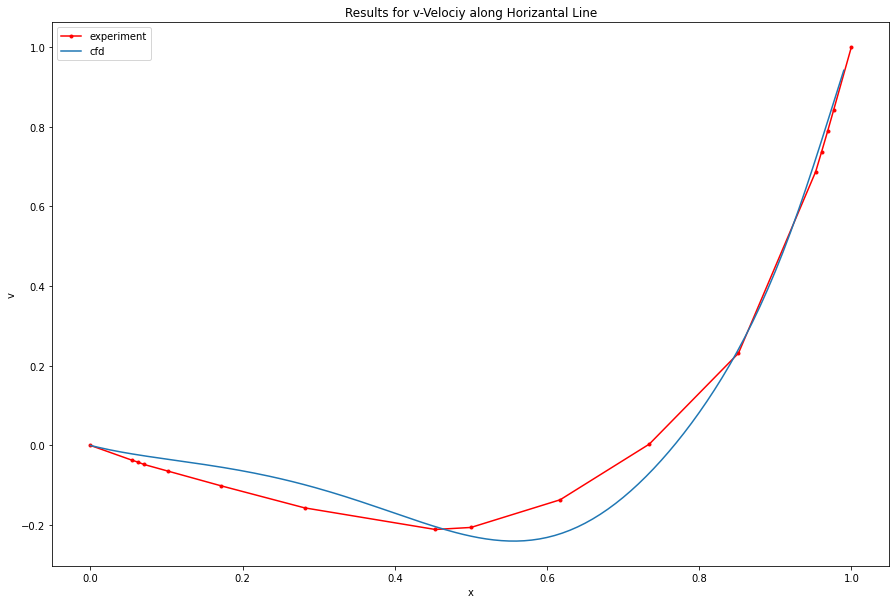

In [ ]:
x = [0, 0.0547, 0.0625, 0.0703, 0.1016,0.1719,0.2813,0.4531,0.5,0.6172,0.7344,0.8516,0.9531,0.9609,0.9688,0.9766,1]

y = [0.0, -0.03717, -0.04192, -0.04775, -.06434, -0.10150, -0.15662, -0.2109, -0.20581, -0.13641, 0.00332, 0.23151, 0.68717, 0.73722, 0.78871, 0.84123, 1]

plt.figure(figsize=(15,10))
plt.plot(x,y,'r.-',label='experiment')
plt.plot(np.linspace(0,1,C3.nx)[:-2],C3.v[:,int(C3.v.shape[0]/2)][:-2],label='cfd')
plt.legend()
plt.title("Results for v-Velociy along Horizantal Line")
plt.xlabel("x")
plt.ylabel("v")

plt.savefig("v.svg")
files.download("v.svg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

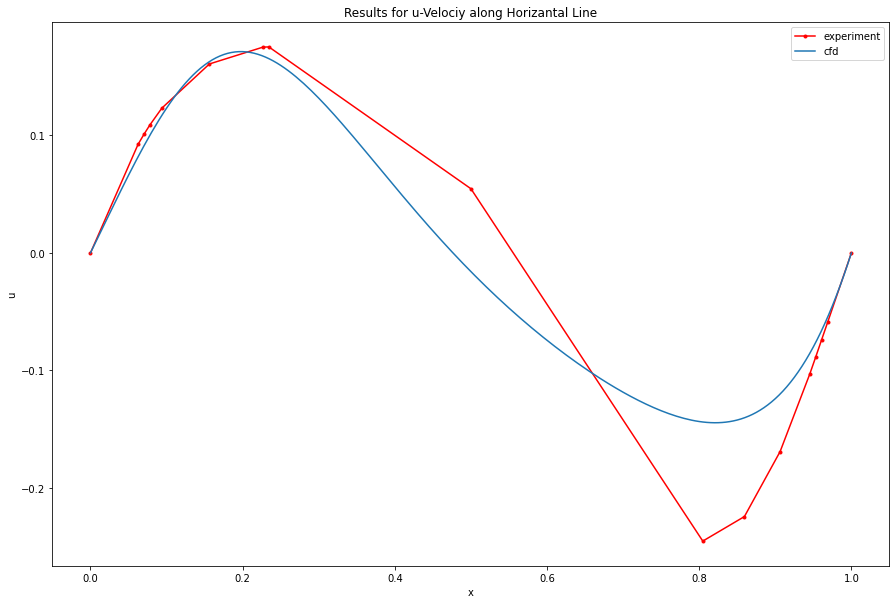

In [ ]:
 
x = [1, 0.9688 ,0.9609 ,0.9531 ,0.9453 ,0.9063 ,0.8594 ,0.8047 ,0.5000 ,0.2344 ,0.2266 ,0.1563 ,0.0938 ,0.0781 ,0.0703 ,0.0625  ,0.0000 ]
y = [0.00000 ,-0.05906 ,-0.07391 ,-0.08864 ,-0.10313 ,-0.16914 ,-0.22445 ,-0.24533 ,0.05454 ,0.17527 ,0.17507 ,0.16077 ,0.12317 ,0.10890 ,0.10091 ,0.09233 ,0.0]
plt.figure(figsize=(15,10))
plt.plot(x,y,'r.-',label='experiment')
plt.plot(np.linspace(0,1,C3.nx),C3.u[int(C3.u.shape[0]/2),:],label='cfd')
plt.legend()
plt.title("Results for u-Velociy along Horizantal Line")
plt.xlabel("x")
plt.ylabel("u")

plt.savefig("u.svg")
files.download("u.svg")
